# 🌳 Modelo de Árbol de Decisión - Clasificación de Imágenes OCT
## Decision Tree Classifier para Clasificación Multiclase

---

En este notebook aplicaremos un **Árbol de Decisión** para clasificar imágenes OCT retinales.

### 📦 Dataset:
- **Fuente:** Kermany et al. 2018 Mendeley Data V3
- **Total:** 109,309 imágenes JPEG
- **Split:** 70% train (~76,500), 20% val (~21,900), 10% test (~10,900)
- **Clases:** CNV, DME, DRUSEN, NORMAL

### 🎯 Características del Árbol de Decisión:
- **Tipo:** DecisionTreeClassifier de sklearn
- **Características:** Las imágenes se redimensionan a 64×64 en escala de grises y se aplanan en vectores 1D
- **Estructura:** Árbol de decisiones jerárquico basado en splits de features
- **Interpretabilidad:** Alta, se puede visualizar el árbol completo
- **Ventajas:** No requiere normalización, captura relaciones no lineales
- **Optimización de memoria:** Imágenes reducidas a 64×64 en escala de grises para caber en RAM
- **Subset de datos:** Usaremos solo 40% del train para optimizar memoria y tiempo de entrenamiento

---

## 1. 📥 Carga de Datos con Data Loaders

Primero cargamos los datos usando los data loaders que ya configuramos.

In [3]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================
import os

# Silenciar logs informativos de TensorFlow (debe ir antes de importar tf)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# ============================================================================
# CONFIGURACIÓN DE MEMORIA GPU
# ============================================================================
# Configurar TensorFlow para liberar memoria y no cargar todo en GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Habilitar memory growth (asignar memoria según se necesite)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ {len(gpus)} GPU(s) configuradas con memory growth")
    except RuntimeError as e:
        print(f"⚠️  Error configurando GPUs: {e}")

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Importar módulo de dataloaders (solo si se ejecuta localmente)
try:
    import oct_dataloader as dataloaders
    print("✅ Módulo oct_dataloader importado (ejecución local)")
except ImportError:
    print("⚠️  oct_dataloader no encontrado - usar funciones embebidas para Colab")
    dataloaders = None

# Configuración
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ 4 GPU(s) configuradas con memory growth
✅ Módulo oct_dataloader importado (ejecución local)
✅ Librerías importadas correctamente


### 📝 Nota para Google Colab:
Si ejecutas este notebook en **Google Colab**, ejecuta la celda siguiente para definir las funciones necesarias del dataloader.

Si ejecutas **localmente** (tienes el archivo `oct_dataloader.py`), puedes saltarte la siguiente celda.

In [4]:
# ============================================================================
# FUNCIONES DE DATALOADER EMBEBIDAS (PARA GOOGLE COLAB)
# ============================================================================
# Solo ejecuta esta celda si estás en Colab o no tienes el archivo oct_dataloader.py

if dataloaders is None:
    from typing import Tuple, Optional
    
    class dataloaders:
        @staticmethod
        def create_oct_dataloaders(
            data_path: str,
            img_size: Tuple[int, int] = (224, 224),
            batch_size: int = 32,
            train_subset_fraction: float = 1.0,
            seed: int = 42,
            validation_split: Optional[float] = None,
            optimize: bool = True,
            verbose: bool = True
        ):
            """Crea dataloaders para el dataset OCT con configuración flexible."""
            
            class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
            
            if verbose:
                print("⚙️ Configuración de DataLoaders")
                print(f"   • Tamaño de imagen: {img_size}")
                print(f"   • Batch size: {batch_size}")
                print(f"   • Clases: {class_names}")
                print(f"   • Train subset: {train_subset_fraction*100:.1f}%")
                print(f"   • Seed: {seed}\n")
            
            # DATA LOADER DE ENTRENAMIENTO
            train_path = os.path.join(data_path, 'train')
            
            if not os.path.exists(train_path):
                raise ValueError(f"No se encontró la carpeta de entrenamiento en: {train_path}")
            
            if verbose:
                print("📦 Creando data loader de entrenamiento...")
            
            train_dataset = tf.keras.utils.image_dataset_from_directory(
                train_path,
                labels='inferred',
                label_mode='int',
                class_names=class_names,
                color_mode='grayscale',
                batch_size=batch_size,
                image_size=img_size,
                shuffle=True,
                seed=seed
            )
            
            if train_subset_fraction < 1.0:
                total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
                subset_batches = max(1, int(total_batches * train_subset_fraction))
                train_dataset = train_dataset.take(subset_batches)
                
                if verbose:
                    print(f"   ⚠️  Usando {train_subset_fraction*100:.1f}% del dataset de entrenamiento")
                    print(f"   ⚠️  Batches: {subset_batches} de {total_batches}")
            
            if optimize:
                train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
                if verbose:
                    print(f"✅ Data loader de entrenamiento creado (con optimización)")
            else:
                if verbose:
                    print(f"✅ Data loader de entrenamiento creado")
            
            # DATA LOADER DE VALIDACIÓN
            val_path = os.path.join(data_path, 'val')
            val_dataset = None
            
            if os.path.exists(val_path):
                if verbose:
                    print("\n📦 Creando data loader de validación...")
                
                val_dataset = tf.keras.utils.image_dataset_from_directory(
                    val_path,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='grayscale',
                    batch_size=batch_size,
                    image_size=img_size,
                    shuffle=False
                )
                
                if optimize:
                    val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
                    if verbose:
                        print(f"✅ Data loader de validación creado (con optimización)")
                else:
                    if verbose:
                        print(f"✅ Data loader de validación creado")
            
            # DATA LOADER DE PRUEBA
            test_path = os.path.join(data_path, 'test')
            test_dataset = None
            
            if os.path.exists(test_path):
                if verbose:
                    print("\n📦 Creando data loader de prueba...")
                
                test_dataset = tf.keras.utils.image_dataset_from_directory(
                    test_path,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='grayscale',
                    batch_size=batch_size,
                    image_size=img_size,
                    shuffle=False
                )
                
                if optimize:
                    test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
                    if verbose:
                        print(f"✅ Data loader de prueba creado (con optimización)")
                else:
                    if verbose:
                        print(f"✅ Data loader de prueba creado")
            
            if verbose:
                print("\n" + "="*60)
                print("📊 RESUMEN DE DATASETS")
                print("="*60)
                
                if train_dataset:
                    train_cardinality = tf.data.experimental.cardinality(train_dataset).numpy()
                    print(f"Train:      {train_cardinality} batches")
                
                if val_dataset:
                    val_cardinality = tf.data.experimental.cardinality(val_dataset).numpy()
                    print(f"Validation: {val_cardinality} batches")
                
                if test_dataset:
                    test_cardinality = tf.data.experimental.cardinality(test_dataset).numpy()
                    print(f"Test:       {test_cardinality} batches")
                
                print("="*60 + "\n")
            
            return train_dataset, val_dataset, test_dataset, class_names
        
        @staticmethod
        def dataloader_to_arrays(dataset, dataset_name="Dataset", limit=None, verbose=True):
            """Convierte un tf.data.Dataset a arrays numpy (X, y)."""
            
            X_list = []
            y_list = []
            total_samples = 0
            
            if verbose:
                print(f"🔄 Convirtiendo {dataset_name} a arrays numpy...")
            
            for images, labels in dataset:
                X_list.append(images.numpy())
                y_list.append(labels.numpy())
                total_samples += images.shape[0]
                
                if limit is not None and total_samples >= limit:
                    if verbose:
                        print(f"   ⚠️  Límite alcanzado: {total_samples} muestras")
                    break
                
                if verbose and len(X_list) % 100 == 0:
                    print(f"   Procesados {len(X_list)} batches ({total_samples} muestras)...")
            
            X = np.concatenate(X_list, axis=0)
            y = np.concatenate(y_list, axis=0)
            
            if limit is not None and X.shape[0] > limit:
                X = X[:limit]
                y = y[:limit]
            
            if verbose:
                print(f"✅ {dataset_name}: {X.shape[0]:,} muestras")
                print(f"   Shape: {X.shape}")
            
            return X, y
    
    print("✅ Funciones de dataloader cargadas para Colab")
else:
    print("ℹ️  Usando módulo oct_dataloader.py (ejecución local)")

ℹ️  Usando módulo oct_dataloader.py (ejecución local)


In [5]:
# ============================================================================
# CARGAR DATASET CON KAGGLEHUB
# ============================================================================
import kagglehub

# Descargar dataset
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print(f"📦 Dataset descargado en: {path}")

# Buscar la estructura correcta del dataset
data_path = path
for root, dirs, files in os.walk(path):
    if 'train' in dirs and 'test' in dirs:
        data_path = root
        print(f"✅ Estructura de datos encontrada en: {data_path}")
        break

# Verificar carpetas
if os.path.exists(os.path.join(data_path, 'train')):
    print(f"   ✓ Carpeta train encontrada")
if os.path.exists(os.path.join(data_path, 'val')):
    print(f"   ✓ Carpeta val encontrada")
if os.path.exists(os.path.join(data_path, 'test')):
    print(f"   ✓ Carpeta test encontrada")

📦 Dataset descargado en: /home/palodo2/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2
✅ Estructura de datos encontrada en: /home/palodo2/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test
   ✓ Carpeta train encontrada
   ✓ Carpeta val encontrada
   ✓ Carpeta test encontrada


## 2. ⚙️ Configuración de Data Loaders

Creamos los data loaders para cargar imágenes eficientemente.

In [6]:
# ============================================================================
# CONFIGURACIÓN DE DATA LOADERS
# ============================================================================

# Parámetros - Reducimos tamaño para optimizar memoria
IMG_SIZE = (64, 64)  # Imágenes más pequeñas para caber en RAM
BATCH_SIZE = 32

# Crear dataloaders - SIN cache para evitar llenar la GPU
train_dataset, val_dataset, test_dataset, class_names = dataloaders.create_oct_dataloaders(
    data_path=data_path,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    verbose=True,
    train_subset_fraction=0.4,  # Usar solo 40% del train para optimizar memoria y tiempo
    optimize=False  # Desactivar cache para no llenar la GPU
)

print(f"\n✅ DataLoaders creados correctamente")
print(f"   Clases: {class_names}")

⚙️ Configuración de DataLoaders
   • Tamaño de imagen: (64, 64)
   • Batch size: 32
   • Clases: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
   • Train subset: 40.0%
   • Seed: 42

📦 Creando data loader de entrenamiento...
Found 76515 files belonging to 4 classes.


I0000 00:00:1772215510.702395 2473282 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77262 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:05:00.0, compute capability: 9.0
I0000 00:00:1772215510.704844 2473282 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78378 MB memory:  -> device: 1, name: NVIDIA H100 PCIe, pci bus id: 0000:09:00.0, compute capability: 9.0
I0000 00:00:1772215510.708677 2473282 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78378 MB memory:  -> device: 2, name: NVIDIA H100 PCIe, pci bus id: 0000:8d:00.0, compute capability: 9.0
I0000 00:00:1772215510.711029 2473282 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78378 MB memory:  -> device: 3, name: NVIDIA H100 PCIe, pci bus id: 0000:91:00.0, compute capability: 9.0
E0000 00:00:1772215510.840194 2474374 ptx_compiler_helpers.cc:88] *** WARNING *** In

   ⚠️  Usando 40.0% del dataset de entrenamiento
   ⚠️  Batches: 956 de 2392
✅ Data loader de entrenamiento creado

📦 Creando data loader de validación...
Found 21861 files belonging to 4 classes.
✅ Data loader de validación creado

📦 Creando data loader de prueba...
Found 10933 files belonging to 4 classes.
✅ Data loader de prueba creado

📊 RESUMEN DE DATASETS
Train:      956 batches
Validation: 684 batches
Test:       342 batches


✅ DataLoaders creados correctamente
   Clases: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


## 3. 🔄 Conversión de Datos para Modelo de Árbol

Convertimos las imágenes de los data loaders a arrays numpy y las aplanamos.

In [8]:
# ============================================================================
# CONVERTIR DATA LOADERS A ARRAYS
# ============================================================================

print("=" * 70)
print("CONVIRTIENDO DATA LOADERS A ARRAYS")
print("=" * 70)

# Convertir todos los datasets (sin mostrar logs cada 100 batches)
X_train, y_train = dataloaders.dataloader_to_arrays(
    train_dataset, 
    "Train"
)

X_val, y_val = dataloaders.dataloader_to_arrays(
    val_dataset, 
    "Validación"
)

X_test, y_test = dataloaders.dataloader_to_arrays(
    test_dataset, 
    "Test"
)

print(f"\n✅ Conversión completada")
print(f"   Train: {X_train.shape[0]:,} muestras")
print(f"   Val:   {X_val.shape[0]:,} muestras")
print(f"   Test:  {X_test.shape[0]:,} muestras")

CONVIRTIENDO DATA LOADERS A ARRAYS
🔄 Convirtiendo Train a arrays numpy...
   Procesados 100 batches (3200 muestras)...
   Procesados 200 batches (6400 muestras)...
   Procesados 300 batches (9600 muestras)...
   Procesados 400 batches (12800 muestras)...
   Procesados 500 batches (16000 muestras)...
   Procesados 600 batches (19200 muestras)...
   Procesados 700 batches (22400 muestras)...
   Procesados 800 batches (25600 muestras)...
   Procesados 900 batches (28800 muestras)...
✅ Train: 30,592 muestras
   Shape: (30592, 64, 64, 3)
🔄 Convirtiendo Validación a arrays numpy...
   Procesados 100 batches (3200 muestras)...
   Procesados 200 batches (6400 muestras)...
   Procesados 300 batches (9600 muestras)...
   Procesados 400 batches (12800 muestras)...
   Procesados 500 batches (16000 muestras)...
   Procesados 600 batches (19200 muestras)...
✅ Validación: 21,861 muestras
   Shape: (21861, 64, 64, 3)
🔄 Convirtiendo Test a arrays numpy...
   Procesados 100 batches (3200 muestras)...
  

### 3.5 🔄 Aplanar Imágenes

Para poder usar el árbol de decisión, necesitamos convertir las imágenes 2D en vectores 1D.

In [9]:
# ============================================================================
# APLANAR IMÁGENES
# ============================================================================

print("\n" + "=" * 70)
print("APLANANDO IMÁGENES")
print("=" * 70)

print(f"\nShape original:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

# Aplanar
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

X_train = X_train.reshape(n_train, -1)
X_val = X_val.reshape(n_val, -1)
X_test = X_test.reshape(n_test, -1)

print(f"\nShape después de aplanar:")
print(f"   X_train: {X_train.shape} ({n_train:,} muestras × {X_train.shape[1]:,} features)")
print(f"   X_val:   {X_val.shape} ({n_val:,} muestras × {X_val.shape[1]:,} features)")
print(f"   X_test:  {X_test.shape} ({n_test:,} muestras × {X_test.shape[1]:,} features)")

print("\n✅ Imágenes aplanadas correctamente")


APLANANDO IMÁGENES

Shape original:
   X_train: (30592, 64, 64, 3)
   X_val:   (21861, 64, 64, 3)
   X_test:  (10933, 64, 64, 3)

Shape después de aplanar:
   X_train: (30592, 12288) (30,592 muestras × 12,288 features)
   X_val:   (21861, 12288) (21,861 muestras × 12,288 features)
   X_test:  (10933, 12288) (10,933 muestras × 12,288 features)

✅ Imágenes aplanadas correctamente


---

## 4. 🌳 Entrenamiento del Árbol de Decisión

Entrenamos un **Decision Tree Classifier** con los datos aplanados.

### 🎯 Hiperparámetros del Árbol:
- **max_depth:** Profundidad máxima del árbol (None = sin límite)
- **min_samples_split:** Mínimo de muestras para dividir un nodo
- **min_samples_leaf:** Mínimo de muestras en una hoja
- **criterion:** Criterio de split ('gini' o 'entropy')
- **random_state:** Semilla para reproducibilidad

In [10]:
# ============================================================================
# ENTRENAR ÁRBOL DE DECISIÓN
# ============================================================================

print("=" * 70)
print("🎓 ENTRENANDO ÁRBOL DE DECISIÓN")
print("=" * 70)

# Crear el modelo
# Limitamos la profundidad para evitar overfitting
arbol_decision = DecisionTreeClassifier(
    max_depth=20,              # Profundidad máxima del árbol
    min_samples_split=100,     # Mínimo de muestras para dividir
    min_samples_leaf=50,       # Mínimo de muestras en hojas
    criterion='gini',          # Criterio de split
    random_state=42
)

# Entrenar el modelo
print("\n🚀 Entrenando...")
print("   (Esto puede tomar varios minutos...)\n")
arbol_decision.fit(X_train, y_train)

print("\n✅ Modelo entrenado correctamente")

# Información del modelo
print("\n" + "=" * 70)
print("📊 INFORMACIÓN DEL MODELO")
print("=" * 70)
print(f"   • Tipo: Árbol de Decisión")
print(f"   • Número de clases: {len(arbol_decision.classes_)}")
print(f"   • Clases: {arbol_decision.classes_}")
print(f"   • Profundidad del árbol: {arbol_decision.get_depth()}")
print(f"   • Número de hojas: {arbol_decision.get_n_leaves():,}")
print(f"   • Número de features: {arbol_decision.n_features_in_:,}")
print(f"   • Criterion: {arbol_decision.criterion}")

🎓 ENTRENANDO ÁRBOL DE DECISIÓN

🚀 Entrenando...
   (Esto puede tomar varios minutos...)


✅ Modelo entrenado correctamente

📊 INFORMACIÓN DEL MODELO
   • Tipo: Árbol de Decisión
   • Número de clases: 4
   • Clases: [0 1 2 3]
   • Profundidad del árbol: 20
   • Número de hojas: 438
   • Número de features: 12,288
   • Criterion: gini


## 5. 📈 Evaluación del Modelo

Evaluamos el modelo en los tres conjuntos: entrenamiento, validación y test.

In [11]:
# ============================================================================
# FUNCIÓN DE EVALUACIÓN
# ============================================================================

def evaluar_modelo(modelo, X, y, conjunto_nombre):
    """
    Evalúa el modelo en un conjunto de datos.
    """
    print(f"\n{'=' * 70}")
    print(f"📊 EVALUACIÓN EN {conjunto_nombre.upper()}")
    print('=' * 70)
    
    # Predicciones
    print(f"Prediciendo...")
    y_pred = modelo.predict(X)
    
    # Métricas
    accuracy = accuracy_score(y, y_pred)
    print(f"\n✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Reporte de clasificación
    print(f"\n📋 Reporte de Clasificación:")
    print("-" * 70)
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    report = classification_report(y, y_pred, target_names=class_names, digits=4)
    print(report)
    
    return accuracy, y_pred

# Evaluar en los tres conjuntos
acc_train, y_pred_train = evaluar_modelo(arbol_decision, X_train, y_train, "Entrenamiento")
acc_val, y_pred_val = evaluar_modelo(arbol_decision, X_val, y_val, "Validación")
acc_test, y_pred_test = evaluar_modelo(arbol_decision, X_test, y_test, "Test")


📊 EVALUACIÓN EN ENTRENAMIENTO
Prediciendo...

✅ Accuracy: 0.6875 (68.75%)

📋 Reporte de Clasificación:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         CNV     0.6649    0.7751    0.7158     10319
         DME     0.5551    0.1675    0.2573      3308
      DRUSEN     0.3145    0.0307    0.0560      2537
      NORMAL     0.7162    0.8596    0.7814     14428

    accuracy                         0.6875     30592
   macro avg     0.5627    0.4582    0.4526     30592
weighted avg     0.6482    0.6875    0.6424     30592


📊 EVALUACIÓN EN VALIDACIÓN
Prediciendo...

✅ Accuracy: 0.6072 (60.72%)

📋 Reporte de Clasificación:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         CNV     0.5808    0.6637    0.6195      7491
         DME     0.4131    0.1332    0.2015      2319
      DRUSEN     0.0909    0.0096    0.0173      1773
 

## 6. 📊 Visualización de Resultados

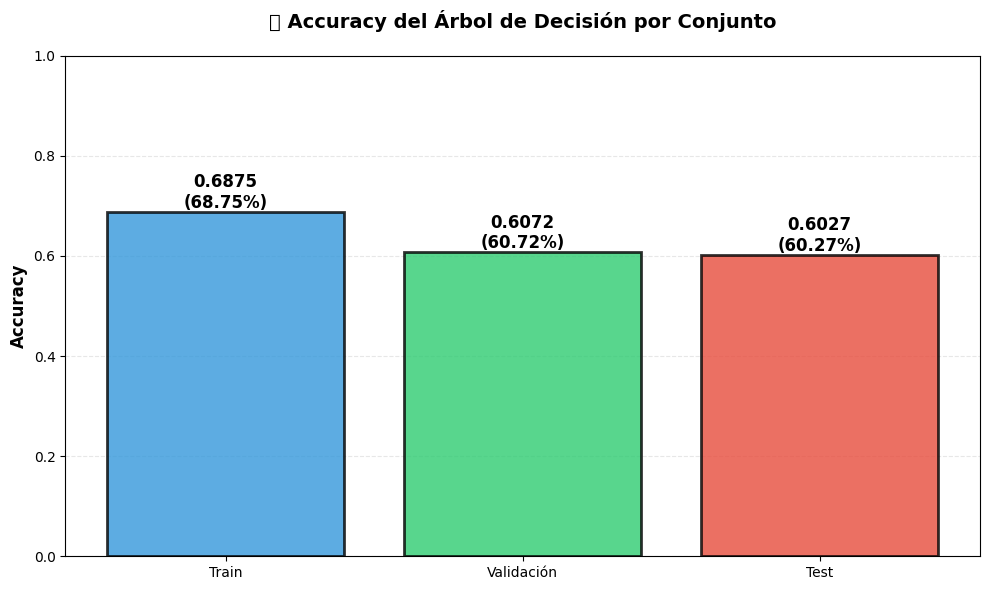

In [12]:
# ============================================================================
# GRÁFICO DE BARRAS CON ACCURACIES
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

conjuntos = ['Train', 'Validación', 'Test']
accuracies = [acc_train, acc_val, acc_test]
colores = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(conjuntos, accuracies, color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Añadir valores sobre las barras
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('📊 Accuracy del Árbol de Decisión por Conjunto', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

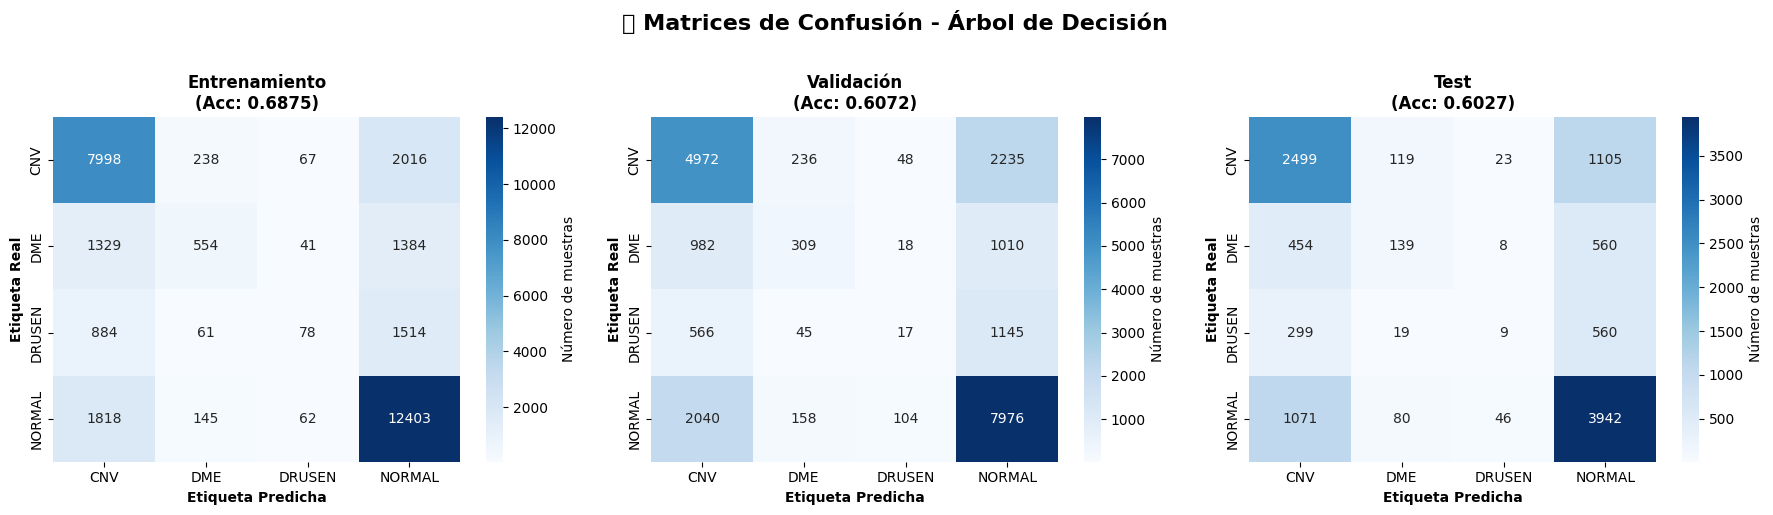

In [13]:
# ============================================================================
# MATRICES DE CONFUSIÓN
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🔍 Matrices de Confusión - Árbol de Decisión', fontsize=16, fontweight='bold', y=1.02)

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
datasets = [
    (y_train, y_pred_train, 'Entrenamiento', axes[0]),
    (y_val, y_pred_val, 'Validación', axes[1]),
    (y_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, titulo, ax in datasets:
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Número de muestras'})
    ax.set_title(f'{titulo}\n(Acc: {accuracy_score(y_true, y_pred):.4f})', 
                 fontweight='bold', fontsize=12)
    ax.set_ylabel('Etiqueta Real', fontweight='bold')
    ax.set_xlabel('Etiqueta Predicha', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 7. 📋 Tabla de Resultados Final

Resumen de los resultados para incluir en el README.

In [14]:
# ============================================================================
# CREAR TABLA DE RESULTADOS
# ============================================================================

print("\n" + "=" * 70)
print(" " * 20 + "📊 RESULTADOS FINALES")
print("=" * 70)

# Calcular número de nodos (aproximación del número de parámetros)
n_nodes = arbol_decision.tree_.node_count
n_params = n_nodes

resultados = {
    'Modelo': ['Árbol de Decisión'],
    'Nodos': [f'{n_nodes:,}'],
    'Profundidad': [arbol_decision.get_depth()],
    'Acc Train': [f'{acc_train:.4f}'],
    'Acc Validación': [f'{acc_val:.4f}'],
    'Acc Test': [f'{acc_test:.4f}']
}

df_resultados = pd.DataFrame(resultados)
print("\n")
print(df_resultados.to_string(index=False))
print("\n" + "=" * 70)

# Guardar también en formato markdown para el README
print("\n📄 Formato Markdown para README:")
print("\n```markdown")
print("| Modelo | Nodos | Profundidad | Acc Train | Acc Validación | Acc Test |")
print("|--------|-------|-------------|-----------|----------------|----------|")
print(f"| Árbol de Decisión | {n_nodes:,} | {arbol_decision.get_depth()} | {acc_train:.4f} | {acc_val:.4f} | {acc_test:.4f} |")
print("```")


                    📊 RESULTADOS FINALES


           Modelo Nodos  Profundidad Acc Train Acc Validación Acc Test
Árbol de Decisión   875           20    0.6875         0.6072   0.6027


📄 Formato Markdown para README:

```markdown
| Modelo | Nodos | Profundidad | Acc Train | Acc Validación | Acc Test |
|--------|-------|-------------|-----------|----------------|----------|
| Árbol de Decisión | 875 | 20 | 0.6875 | 0.6072 | 0.6027 |
```


---

## 8. 💾 Guardar Modelo

Guardamos el modelo entrenado para uso futuro.

In [ ]:
# ============================================================================
# GUARDAR MODELO
# ============================================================================
import joblib

# Crear carpeta de modelos si no existe
os.makedirs('modelos', exist_ok=True)

# Guardar el modelo
modelo_path = 'modelos/arbol_decision.pkl'
joblib.dump(arbol_decision, modelo_path)

print(f"✅ Modelo guardado en: {modelo_path}")
print(f"   Tamaño del archivo: {os.path.getsize(modelo_path) / 1024 / 1024:.2f} MB")

---

## 9. 🔍 Análisis de Feature Importance

Los árboles de decisión nos permiten ver qué píxeles son más importantes para la clasificación.

In [ ]:
# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

print("=" * 70)
print("🔍 IMPORTANCIA DE FEATURES (PÍXELES)")
print("=" * 70)

# Obtener importancias
importances = arbol_decision.feature_importances_

# Estadísticas
print(f"\n📊 Estadísticas de importancia:")
print(f"   • Features totales: {len(importances):,}")
print(f"   • Features usados (importance > 0): {np.sum(importances > 0):,}")
print(f"   • Importancia máxima: {np.max(importances):.6f}")
print(f"   • Importancia promedio: {np.mean(importances):.6f}")

# Top 10 features más importantes
top_indices = np.argsort(importances)[::-1][:10]
print(f"\n🏆 Top 10 píxeles más importantes:")
for i, idx in enumerate(top_indices, 1):
    print(f"   {i}. Píxel {idx}: {importances[idx]:.6f}")

# Visualizar mapa de calor de importancia
importance_map = importances.reshape(64, 64)  # Escala de grises (1 canal)

plt.figure(figsize=(10, 8))
plt.imshow(importance_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Importancia')
plt.title('🔥 Mapa de Calor - Importancia de Píxeles', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Píxel X')
plt.ylabel('Píxel Y')
plt.tight_layout()
plt.show()

print("\n✅ Las regiones más rojas indican los píxeles más importantes para la clasificación")